In [1]:
import numpy as np
import pysam
import re
from Bio import SeqIO
from matplotlib import pyplot as plt
%matplotlib inline

# Methods

In [5]:
def coverage_stats(filename, dataset, blocksize=1000):
    coverage = []
    genome_len, covered = 0, 0
    with open(filename) as f:
        for line in f:
            line = line.split('\t')
            coverage.append(int(line[2]))
            genome_len += 1
            if int(line[2]) != 0:
                covered += 1
    
    print("Dataset: {}\n"
          "Average coverage: {:.3f}\n"
          "Covered genome percent: {:.3f}%\n"
          .format(dataset, sum(coverage) / genome_len, covered / genome_len * 100))
    
    # count avg coverage per block of blocksize nucleotides
    blocks_avg = [sum(coverage[i:min(genome_len, i + blocksize)]) / min(blocksize, genome_len - i) 
                  for i in range(0, genome_len, blocksize)]
    
    xticks = ["{}-{}".format(i, min(genome_len, i + blocksize))
              for i in range(0, genome_len, blocksize)]
    xrange = [i for i in range(len(xticks))]
    # in case of too much xticks
    if len(xticks) > 50:
        xticks = [xticks[i] for i in range(0, len(xticks), 50)]
        xrange = [xrange[i] for i in range(0, len(xrange), 50)]
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(blocks_avg)), blocks_avg)
    plt.xticks(xrange, xticks, rotation=30, fontsize=8)
    plt.xlabel("nucleotides positions")
    plt.ylabel("average coverage")
    plt.title("Genome coverage")
    plt.show()

In [10]:
def insert_size_plot(filename, dataset):
    insert_sizes = []
    
    with open(filename) as f:
        for line in f:
            line = line.split('\t')
            insert_sizes = insert_sizes + [int(line[0]) for _ in range(int(line[1]))]
    
    avg = sum(insert_sizes) / len(insert_sizes)
    mse = sum([(x - avg) ** 2 for x in insert_sizes]) / len(insert_sizes)
    a, b = min_interval(insert_sizes)
    # as we have bigger density on the left end, 
    # minimal interval should be between 0 and 95 percentile
    
    print("Dataset: {}\n"
          "Mean insert size: {:.3f}\n"
          "Mean square error: {:.3f}\n"
          "Minimal interval containing 95% reads: [{:.3f}, {:.3f}]\n"
          .format(dataset, avg, mse, a, b))
    
    
    x, y = np.unique(insert_sizes, return_counts=True)
    x, y = zip(*sorted(zip(x, y)))
    plt.figure(figsize=(12,5))
    plt.plot(x, y)
    plt.xlabel("insert size")
    plt.ylabel("number of reads")
    plt.title("Insert size distribution")
    plt.show()

In [12]:
def min_interval(ds):
    a1 = 0
    a2 = 5
    b1 = 95
    b2 = 100
    
    while abs(a1 - a2) > 0.001:
        l1 = np.percentile(ds, b1) - np.percentile(ds, a1)
        l2 = np.percentile(ds, b2) - np.percentile(ds, a2)
        if l1 > l2:
            a1 = (a1 + a2) / 2
            b1 = (b1 + b2) / 2
        elif l1 < l2:
            a2 = (a1 + a2) / 2
            b2 = (b1 + b2) / 2
        else:
            return np.percentile(ds, a1), np.percentile(ds, b1)
        
    return np.percentile(ds, a1), np.percentile(ds, b1)

In [6]:
def count_subst_freqs(filename, dataset):
    freqs_matrix = {}
    for ref in ('ACTG-'):
        for alt in ('ACTG-'):
            if alt != ref:
                freqs_matrix[(alt, ref)] = 0
                
    bamfile = pysam.AlignmentFile(filename, 'rb')
    for read in bamfile.fetch():
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue
        
        # remove skippings
        s1 = -1
        s2 = len(aln_pairs)
        while aln_pairs[s1 + 1][1] is None:
            s1 += 1
        while aln_pairs[s2 - 1][1] is None:
            s2 -= 1
        aln_pairs = aln_pairs[s1 + 1 : s2]
            
            
        read_seq = read.seq
        for p in aln_pairs:
            if p[0] is None:
                freqs_matrix[('-', p[2])] += 1
            elif p[1] is None and read_seq[p[0]] != 'N':
                freqs_matrix[(read_seq[p[0]], '-')] += 1
            elif p[1] is not None and p[2].lower() == p[2] and read_seq[p[0]] != 'N':
                freqs_matrix[(read_seq[p[0]], p[2].upper())] += 1
                
    print('Dataset: {}\n'.format(dataset))
    print('   A\t\tC\t\tT\t\tG\t\t-')
    for alt in 'ACTG-':
        print(alt, end='  ')
        for ref in 'ACTG-':
            if alt == ref:
                print('*\t\t', end='')
            else:
                print(freqs_matrix[(alt, ref)], 
                      end='\t' + ('\t' if len(str(freqs_matrix[(alt, ref)])) < 5 or ref != 'A' else ''))
        print()

In [11]:
def count_error_percentage(filename, dataset):
    errors = []
    with open(filename) as f:
        for line in f:
            line = line.split(' ')
            # in other case read didn't aligned
            if line[1].replace('\n', '').isdigit():
                errors.append(int(line[1]) / int(line[0]))
    
    avg = sum(errors) / len(errors)
    
    print("Dataset: {}\n"
          "Mean errors percentage per read: {:.3f}%\n"
          .format(dataset, avg * 100))

In [23]:
def indel_stats(filename, dataset):
    length = []
    ins = []
    dels = []
    
    with open(filename) as f:
        for line in f:
            line = line.replace('\n', '').split('\t')
            length.append(int(line[0]))
            ins.append(int(line[1]))
            dels.append(int(line[2]))
    
    mean_ins = sum([i * l for (i, l) in zip(ins, length)]) / sum(ins)
    mean_dels = sum([d * l for (d, l) in zip(dels, length)]) / sum(dels)
    
    print('Dataset: {}\n'
          'Mean insertion length: {:.3f}\n'
          'Mean deletion length: {:.3f}\n'
          .format(dataset, mean_ins, mean_dels))
    
    plt.figure(figsize=(7, 12))
    plt.subplot(211)
    plt.plot(length, ins)
    plt.xlabel('insertion length')
    plt.ylabel('n insertions')
    plt.title('Insertion length distribution')
    
    plt.subplot(212)
    plt.plot(length, dels)
    plt.xlabel('deletion length')
    plt.ylabel('n deletions')
    plt.title('Deletion length distribution')

In [29]:
def errors_quals(filename, dataset):
    ins_quals = []
    subst_quals = []
    
    bamfile = pysam.AlignmentFile(filename, 'rb')
    for read in bamfile.fetch():
        idx_q = 0
        idx_aln = 0
        aln_pairs = read.get_aligned_pairs(with_seq=True)
        quals = read.query_qualities
        while idx_aln < len(aln_pairs):
            if aln_pairs[idx_aln][0] is None:
                idx_aln += 1
            elif aln_pairs[idx_aln][1] is None:
                ins_quals.append(quals[idx_q])
                idx_q += 1
                idx_aln += 1
            elif aln_pairs[idx_aln][2].lower() == aln_pairs[idx_aln][2]:
                subst_quals.append(quals[idx_q])
                idx_q += 1
                idx_aln += 1
            else: 
                idx_q += 1
                idx_aln += 1
                
    avg_ins_qual = sum(ins_quals) / len(ins_quals)
    avg_subst_qual = sum(subst_quals) / len(subst_quals)
    
    print('Dataset: {}\n'
          'Mean insertion bases quality: {:.3f}\n'
          'Mean substitution bases quality: {:.3f}\n'
          .format(dataset, avg_ins_qual, avg_subst_qual))
    
    ins_distr_x, ins_distr_y = np.unique(ins_quals, return_counts=True)
    subst_distr_x, subst_distr_y = np.unique(subst_quals, return_counts=True)
    
    plt.figure(figsize=(7, 10))
    plt.subplot(211)
    plt.plot(ins_distr_x, ins_distr_y)
    plt.xlabel('quality')
    plt.title('Distribution of insertion base quality')
    
    plt.subplot(212)
    plt.plot(subst_distr_x, subst_distr_y)
    plt.xlabel('quality')
    plt.title('Distribution of substitution base quality')

In [36]:
def homopolymer_indels(filename, dataset):
    hp_indel = {}
    for k in range(3, 11):
        hp_indel[k - 3] = {}
        for g in range(-25, 25):
            hp_indel[k - 3][g] = 0
        
    bamfile = pysam.AlignmentFile(filename, 'rb')
    curr_len = 1
    curr_seg_len = 0
    seg_len_pool = []
    curr_nucl = 'R'
    for read in bamfile.fetch():
        if curr_len > 2  and curr_len < 11:
            hp_indel[curr_len - 3][curr_seg_len - curr_len] += 1
            for l in seg_len_pool:
                hp_indel[curr_len - 3][l - curr_len] += 1
            
        curr_len = 1 
        curr_seg_len = 0
        curr_nucl = 'R'
        seg_len_pool = []
        try:
            aln_pairs = read.get_aligned_pairs(with_seq=True)
        except:
            continue
        
        for p in read.get_aligned_pairs(with_seq=True):
            if p[1] is None:
                if read.seq[p[0]] == curr_nucl:
                    curr_seg_len += 1
                else:
                    if curr_seg_len != 0:
                        seg_len_pool.append(curr_seg_len)
                    curr_seg_len = 0
            else:
                if curr_nucl == p[2].upper():
                    curr_len += 1
                    if p[2].upper() == p[2]:
                        curr_seg_len += 1
                    else:
                        seg_len_pool.append(curr_seg_len)
                        curr_seg_len=0
                else:
                    if curr_len > 2 and curr_len < 11:
                        hp_indel[curr_len - 3][curr_seg_len - curr_len] += 1
                            
                    curr_len = 1
                    curr_nucl = p[2].upper()
                    seg_len_pool = []
                    curr_seg_len = 0
                    if p[0] is not None:
                        i = p[0]
                        while i > -1 and read.seq[i] == curr_nucl:
                            curr_seg_len += 1
                            i -= 1
    
    print(f'Dataset: {dataset}')
                            
    for k in range(3, 11):
        x, y = [], []
        for key, value in hp_indel[k - 3].items():
            x.append(key)
            y.append(value)
        plt.plot(x, y)
        plt.title(f'Homopolymer length: {k}')
        plt.xlabel('difference with ref')
        plt.show()
    

$\Huge\color{red}{\text{Part I}}$

# Processing datasets

``bwa index MG1655-K12.first10K.fasta ``

``bwa mem MG1655-K12.first10K.fasta test_1.fastq test_2.fastq > test_aln.sam``

``samtools flagstat test_aln.sam ``

__Mapped reads for test__ : 56320 (100%)

``bwa index ref.fasta``

``bwa mem ref.fasta frag.R1.fastq frag.R2.fastq > frag_aln.sam``

``samtools flagstat frag_aln.sam ``

__Mapped reads for frag__ : 3424657 (99.77%)

``bwa mem ref.fasta jump.R1.fastq jump.R2.fastq > jump_aln.sam``

``samtools flagstat jump_aln.sam ``

__Mapped reads for jump__ : 4279501 (98.86%)

# Counting coverage

``samtools sort test_aln.sam > test_aln.bam``

``samtools depth test_aln.bam > test_aln.coverage``

``samtools sort frag_aln.sam > frag_aln.bam``

``samtools depth frag_aln.bam > frag_aln.coverage``

``samtools sort jump_aln.sam > jump_aln.bam``

``samtools depth jump_aln.bam > jump_aln.coverage``

Dataset: test
Average coverage: 508.975
Covered genome percent: 100.000%



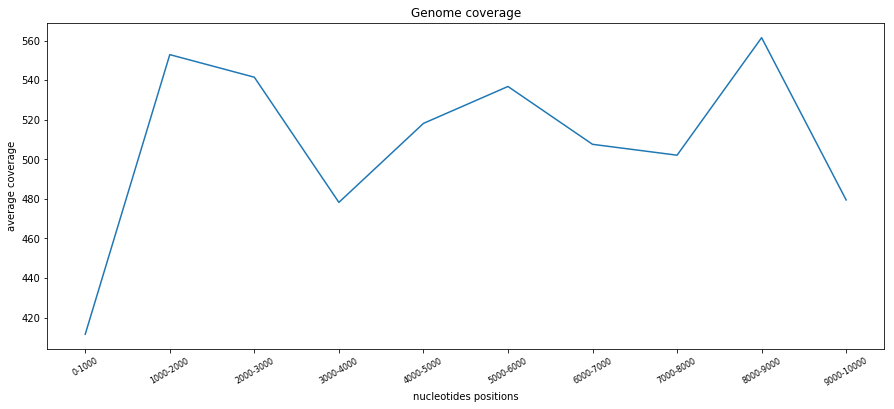

In [48]:
coverage_stats("test_aln.coverage", "test")

Dataset: frag
Average coverage: 130.585
Covered genome percent: 100.000%



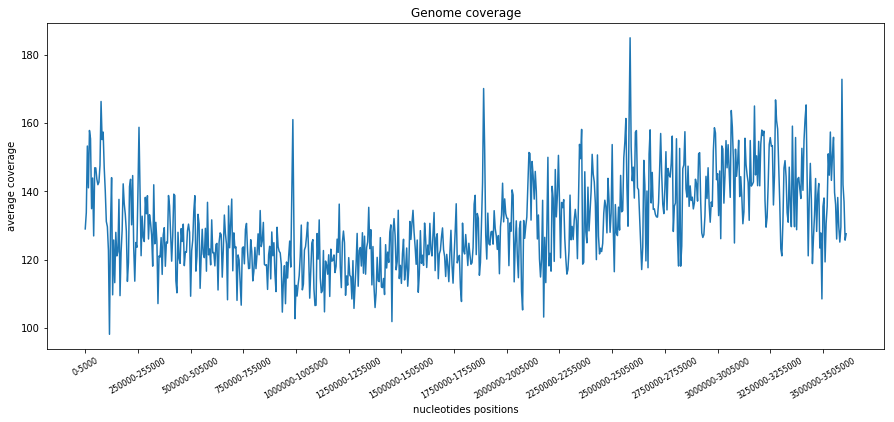

In [49]:
coverage_stats("frag_aln.coverage", "frag", blocksize=5000)

Dataset: jump
Average coverage: 139.921
Covered genome percent: 99.999%



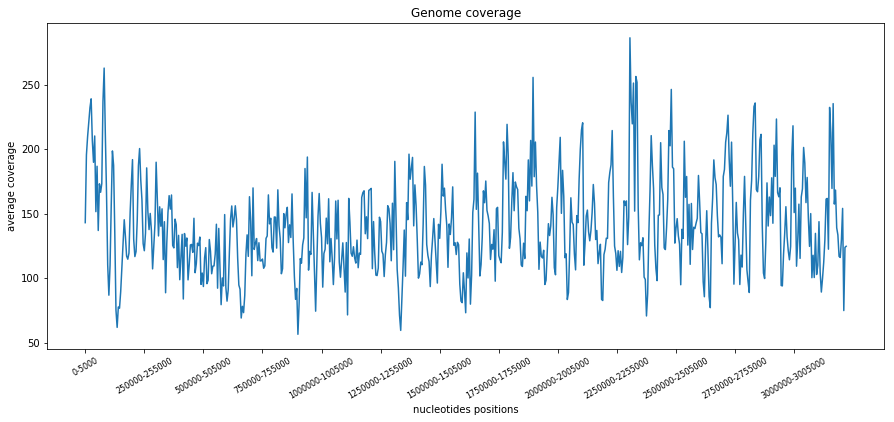

In [51]:
coverage_stats("jump_aln.coverage", "jump", blocksize=5000)

# Insert size distribution

``samtools stats test_aln.sam | grep ^IS | cut -f 2- > test_is``

``samtools stats frag_aln.sam | grep ^IS | cut -f 2- > frag_is``

``samtools stats jump_aln.sam | grep ^IS | cut -f 2- > jump_is``

Dataset: test
Mean insert size: 215.074
Mean square error: 107.307
Minimal interval containing 95% reads: [196.000, 233.000]



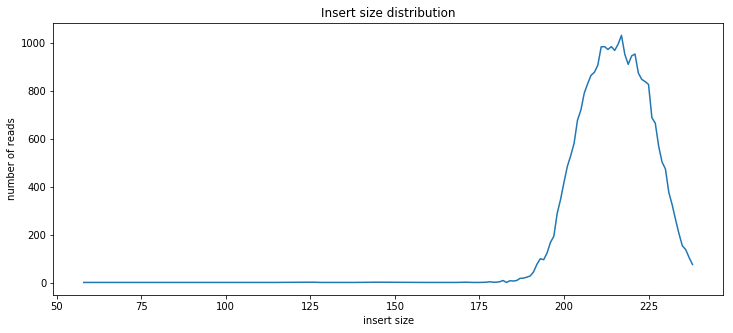

In [13]:
insert_size_plot("test_is", "test")

Dataset: frag
Mean insert size: 267.877
Mean square error: 3733.690
Minimal interval containing 95% reads: [173.000, 410.000]



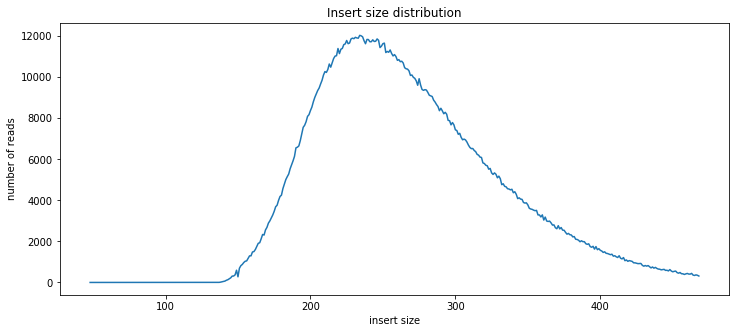

In [14]:
insert_size_plot("frag_is", "frag")

Dataset: jump
Mean insert size: 7255.045
Mean square error: 1261719.836
Minimal interval containing 95% reads: [6210.000, 8000.000]



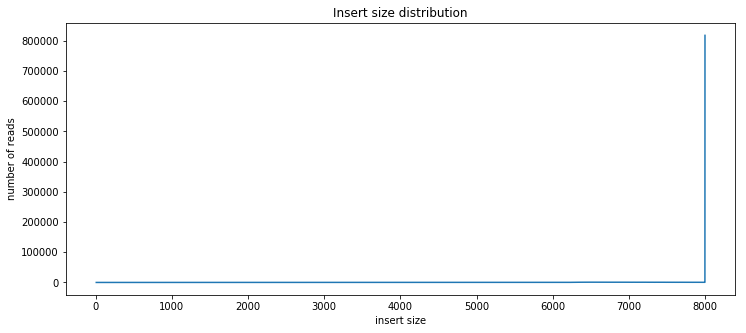

In [94]:
insert_size_plot("jump_is", "jump")

# Substitutions frequencies

In [7]:
count_subst_freqs('test_aln.bam', 'test')

Dataset: test

   A		C		T		G		-
A  *		0		0		0		0		
C  15		*		0		21		0		
T  1		1		*		34		0		
G  19		2		16		*		0		
-  0		0		0		0		*		


In [8]:
count_subst_freqs('frag_aln.bam', 'frag')

Dataset: frag

   A		C		T		G		-
A  *		573779		105845		222038		3481		
C  1464356	*		840420		1112636		9457		
T  104972	220664		*		575060		3648		
G  846317	1113628		1477178		*		9582		
-  5668		7582		5748		7497		*		


In [9]:
count_subst_freqs('jump_aln.bam', 'jump')

Dataset: jump

   A		C		T		G		-
A  *		144778		44396		74508		661		
C  873929	*		506815		480768		2701		
T  44330	75391		*		145191		678		
G  515943	487220		887473		*		2766		
-  3021		4516		2964		4497		*		


# Mean errors percentage

_Parse NM tag and read length:_

``cat test_aln.sam | awk 'NR>2 {split($12, a, ":"); print length($10),a[3]}' > test_errors``

``cat frag_aln.sam | awk 'NR>2 {split($12, a, ":"); print length($10),a[3]}' > frag_errors``

``cat jump_aln.sam | awk 'NR>2 {split($12, a, ":"); print length($10),a[3]}' > jump_errors``

In [26]:
count_error_percentage('test_errors', 'test')

Dataset: test
Mean errors percentage per read: 0.003%



In [27]:
count_error_percentage('frag_errors', 'frag')

Dataset: frag
Mean errors percentage per read: 1.699%



In [28]:
count_error_percentage('jump_errors', 'jump')

Dataset: jump
Mean errors percentage per read: 0.727%



$\Huge\color{red}{\text{Part II}}$

# Processing datasets

``bwa index test_reference.fasta``

``bwa mem test_reference.fasta test.fastq > test_aln.sam``

``samtools flagstat test_aln.sam ``

__Mapped reads for test__ : 0 (0%)

``bwa index DH10B-K12.fasta ``

``bwa mem DH10B-K12.fasta B22-730.fastq > b22_aln.sam``

``samtools flagstat b22_aln.sam``

__Mapped reads for B22-730__ : 489459 (98.41%)

``bwa mem DH10B-K12.fasta C24-698.fastq  > c24_aln.sam``

``samtools flagstat c24_aln.sam``

__Mapped reads for C24-698__ : 682638 (99.41%)

# Counting coverage

``samtools sort b22_aln.sam > b22_aln.bam``

``samtools depth b22_aln.bam > b22_aln.coverage``

``samtools sort c24_aln.sam > c24_aln.bam``

``samtools depth c24_aln.bam > c24_aln.coverage``

Dataset: b22-730
Average coverage: 33.957
Covered genome percent: 100.000%



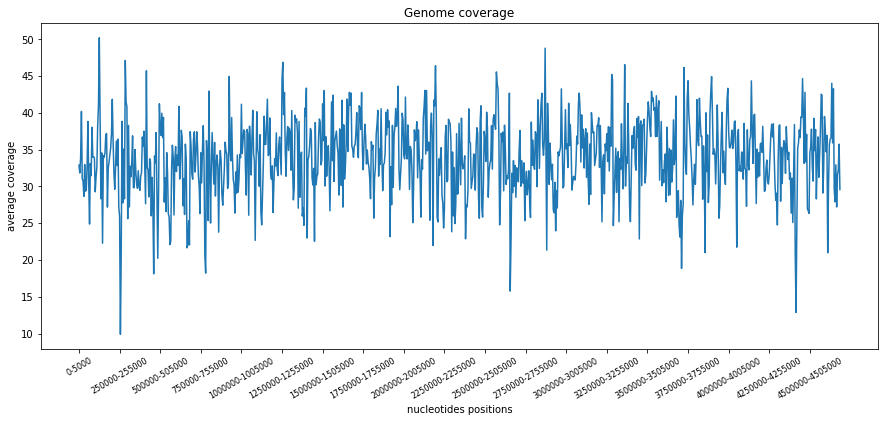

In [90]:
coverage_stats('iontorrent/b22_aln.coverage', 'b22-730', blocksize=5000)

Dataset: c24-698
Average coverage: 35.654
Covered genome percent: 100.000%



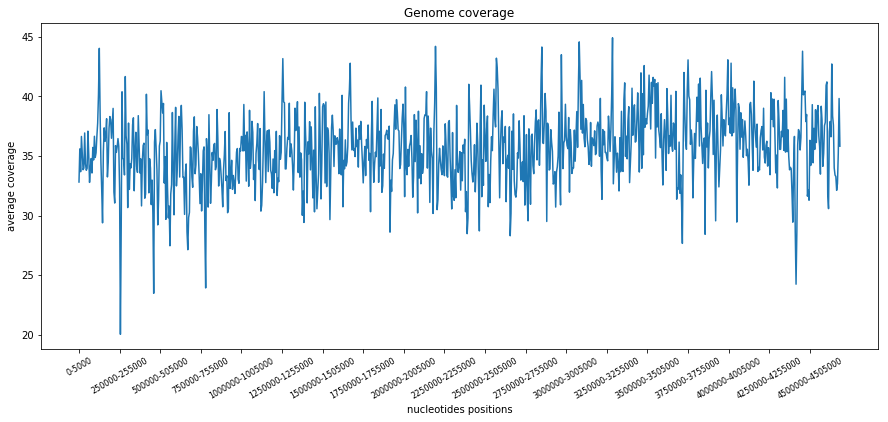

In [91]:
coverage_stats('iontorrent/c24_aln.coverage', 'c24-698', blocksize=5000)

# Mean errors percentage

_Parse NM tag and read length:_

``cat b22_aln.sam | awk 'NR>2 {split($12, a, ":"); print length($10),a[3]}' > b22_errors``

``cat c24_aln.sam | awk 'NR>2 {split($12, a, ":"); print length($10),a[3]}' > c24_errors``

In [5]:
count_error_percentage('iontorrent/b22_errors', 'b22-730')

Dataset: b22-730
Mean errors percentage per read: 0.732%



In [6]:
count_error_percentage('iontorrent/c24_errors', 'c24-698')

Dataset: c24-698
Mean errors percentage per read: 0.407%



# Indels statistics

``samtools stats b22_aln.bam > b22_stats``

``cat b22_stats | grep ^ID | cut -f 2- > b22_indel_distr``

``samtools stats c24_aln.bam > c24_stats``

``cat c24_stats | grep ^ID | cut -f 2- > c24_indel_distr``

Dataset: b22-730
Mean insertion length: 1.090
Mean deletion length: 1.064



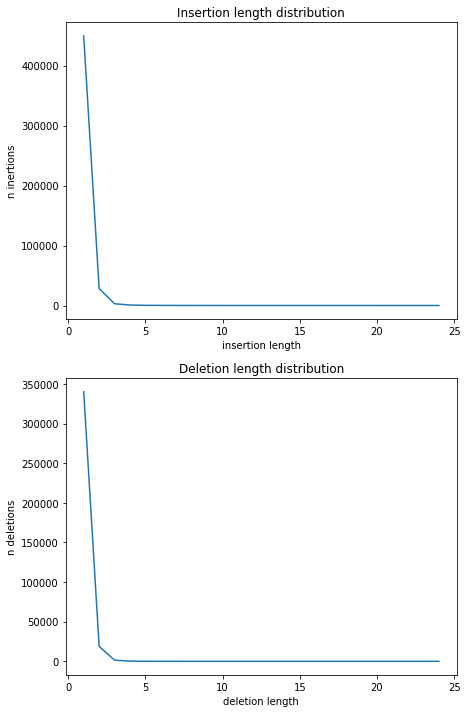

In [22]:
indel_stats('iontorrent/b22_indel_distr', 'b22-730')

Dataset: c24_698
Mean insertion length: 1.080
Mean deletion length: 1.055



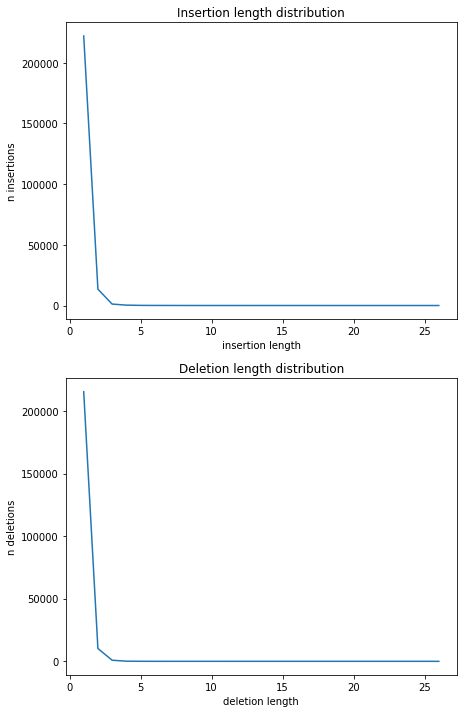

In [24]:
indel_stats('iontorrent/c24_indel_distr', 'c24_698')

# Indels in homopolymers

Dataset: b22-730


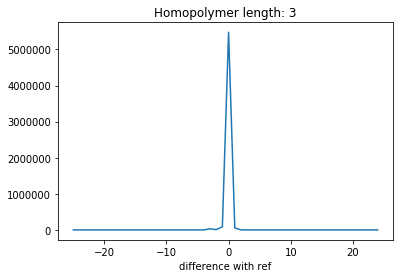

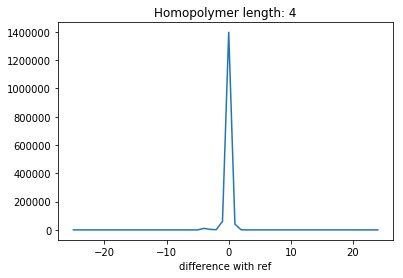

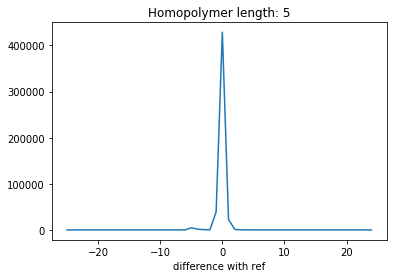

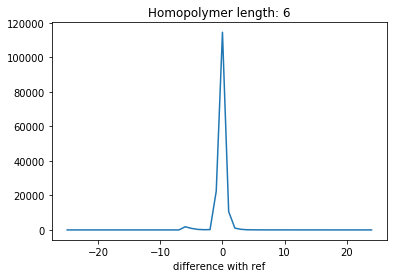

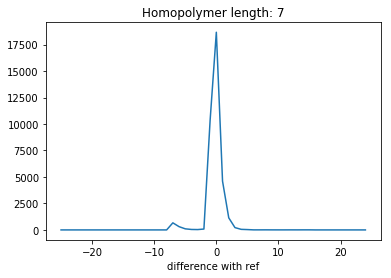

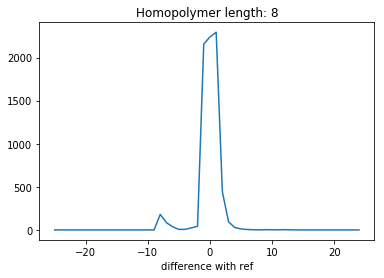

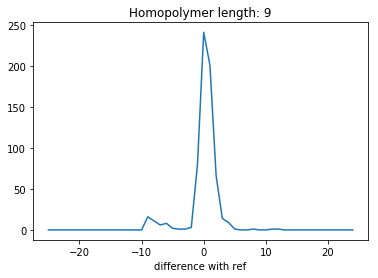

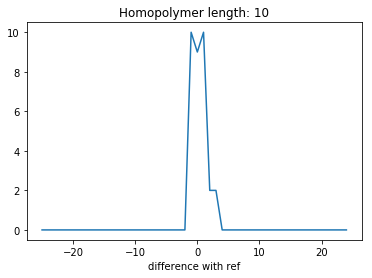

In [37]:
homopolymer_indels('iontorrent/b22_aln.bam', 'b22-730')

Dataset: c24-698


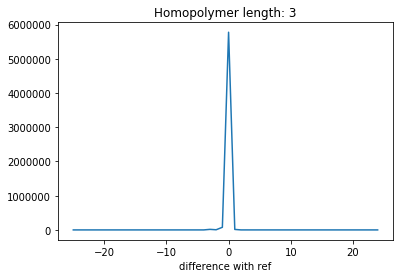

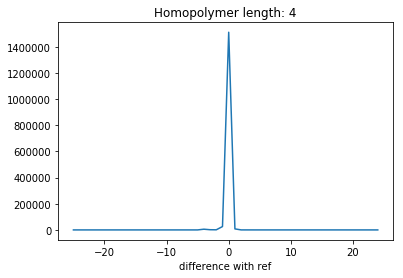

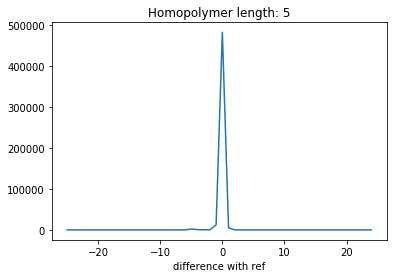

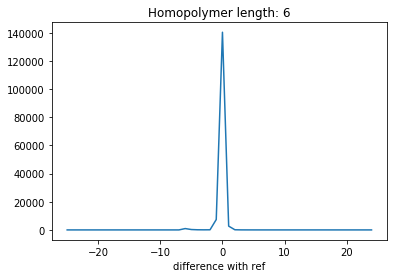

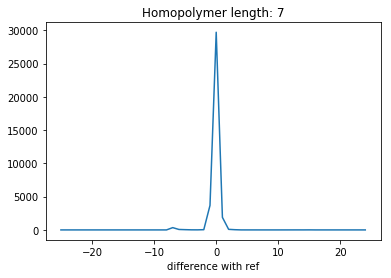

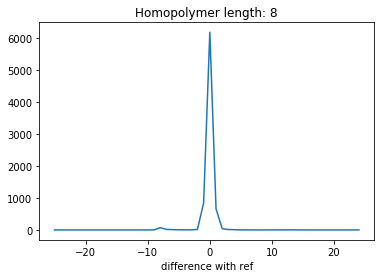

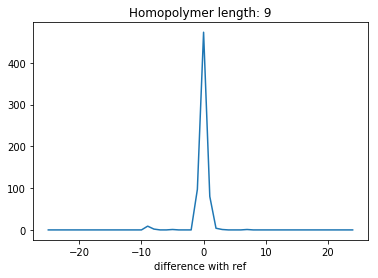

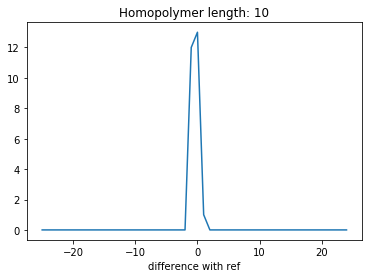

In [39]:
homopolymer_indels('iontorrent/c24_aln.bam', 'c24-698')

# Substitution and insertion bases qualities

Dataset: b22-730
Mean insertion bases quality: 18.484
Mean substitution bases quality: 19.143



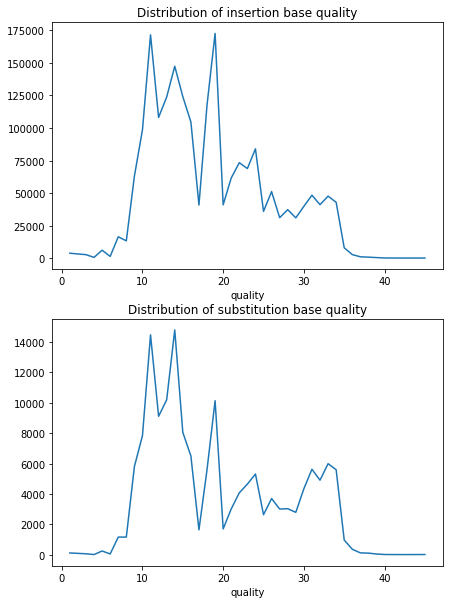

In [30]:
errors_quals('iontorrent/b22_aln.bam', 'b22-730')

Dataset: c24-698
Mean insertion bases quality: 17.926
Mean substitution bases quality: 21.043



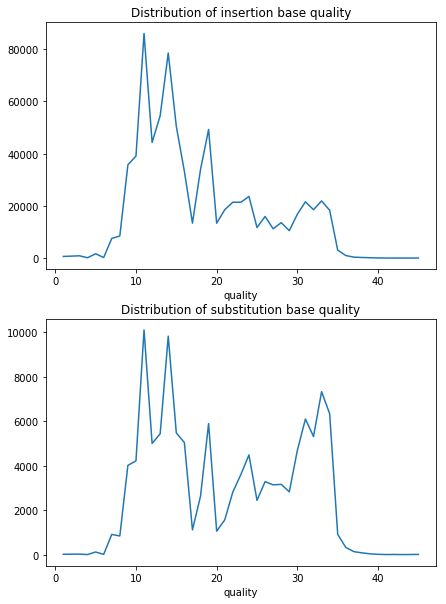

In [32]:
errors_quals('iontorrent/c24_aln.bam', 'c24-698')

# Substitution and indels frequencies

In [92]:
count_subst_freqs('iontorrent/b22_aln.bam', 'b22-730')

Dataset: b22-730

   A		C		T		G		-
A  *		10360		11325		17215		183228		
C  9147		*		24493		7209		79059		
T  11173	16671		*		10563		184506		
G  23657	8092		9060		*		79197		
-  119254	72479		119372		72804		*		


In [93]:
count_subst_freqs('iontorrent/c24_aln.bam', 'c24-698')

Dataset: c24-698

   A		C		T		G		-
A  *		6751		6549		14257		80749		
C  5124		*		22450		4978		47601		
T  6488		13966		*		7069		81446		
G  21938	5380		5248		*		46631		
-  37199	82132		37728		82142		*		


# Repeating results with bowtie2

``bowtie2-build DH10B-K12.fasta dh10b``

``bowtie2 -x dh10b -U B22-730.fastq -S b22_bowtie_aln.sam``

``bowtie2 -x dh10b -U C24-698.fastq -S c24_bowtie_aln.sam``

__Mapped reads for B22-730__ : 448286 (90.58%) aligned exactly 1 time; 35643 (7.20%) aligned >1 times; overall: 97.78%

__Mapped reads for C24-698__ : 629223 (91.80%) aligned exactly 1 time; 51043 (7.45%) aligned >1 times; overall: 99.25%

Dataset: b22-730 bowtie
Average coverage: 33.903
Covered genome percent: 100.000%



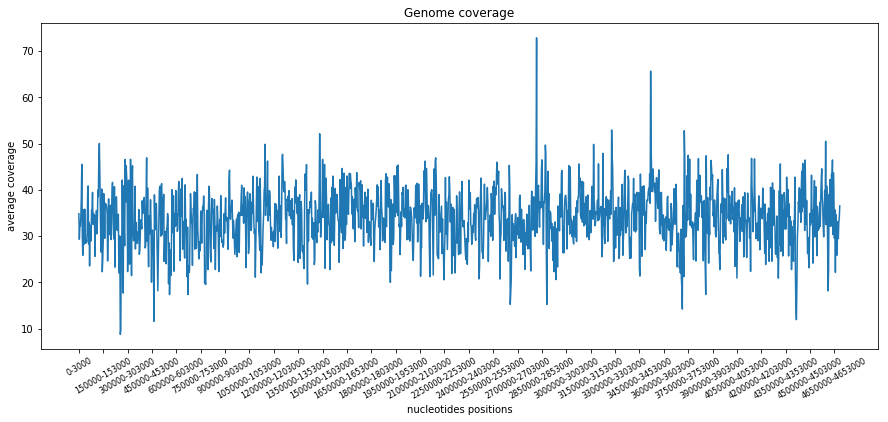

In [9]:
coverage_stats('iontorrent/b22_bowtie_aln.coverage', 'b22-730 bowtie', blocksize=3000)

Dataset: c24-698 bowtie
Average coverage: 35.649
Covered genome percent: 100.000%



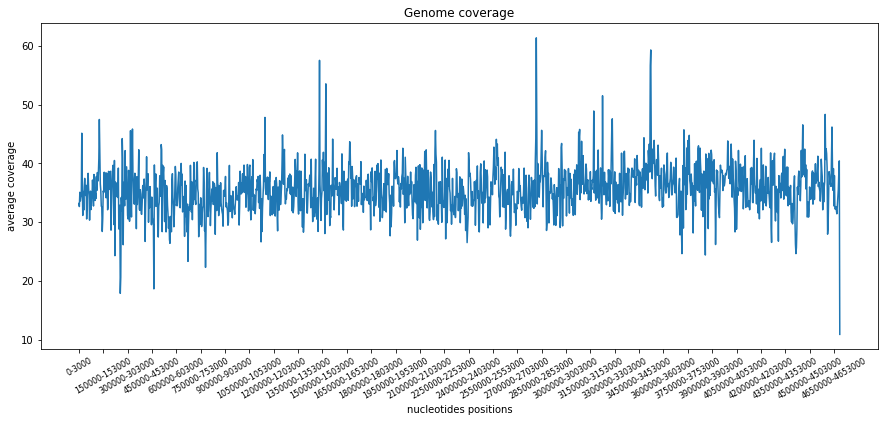

In [10]:
coverage_stats('iontorrent/c24_bowtie_aln.coverage', 'c24-698 bowtie', blocksize=3000)

###  Для ридов, выровненных с помощью bowtie2, процент покрытого генома не изменился по сравнению с выравниванием с помощью bwa mem; среднее покрытие изменилось менее, чем на 0.1.

In [12]:
count_error_percentage('iontorrent/b22_bowtie_errors', 'b22-730 bowtie')

Dataset: b22-730 bowtie
Mean errors percentage per read: 1.115%



In [13]:
count_error_percentage('iontorrent/c24_bowtie_errors', 'c24-698 bowtie')

Dataset: c24-698 bowtie
Mean errors percentage per read: 0.558%



### Средний процент ошибок в ридах возрос на 0.383% для файла B22-730 и на 0.151% для файла C24-698 при выравнивании с помощью bowtie2